# Baseline Model #2

## same as #1 but with 10 year dataset

In [1]:
import myLibrary as mL
import pandas as pd
import numpy as np
import missingno as msno

from pmdarima import auto_arima
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# STATION_LIST = mL.stations_GOM
# YEARS = [str(i) for i in list(range(2013,2023))]
#
# num_records = len(YEARS) * 365 * 24
# NaN_statistic = pd.DataFrame()
# for stationID in STATION_LIST:
#     nan_count = 0
#
#     for year in YEARS:
#         wtmp = mL.get_buoy_data(stationID, year)[f"WTMP_{stationID}"]
#         nan_count = nan_count + wtmp.isna().sum()
#
#     new_row = pd.DataFrame({
#         "StationID": [stationID],
#         "#NaN in %": nan_count / num_records
#     })
#     NaN_statistic = pd.concat([NaN_statistic, new_row])
#
# NaN_statistic

### So over the last 10 years, the station 42022 provides the most values for water temperature. So lets use that for the second model.

In [3]:
STATION_ID = ["42022"]
#YEARS = [str(i) for i in list(range(2013,2023))]

#data, file_nan_count = mL.build_NDBC_dataset(STATION_ID, YEARS)

In [4]:
# file_nan_count

### Even though the plan was to consider 10 years, I will only go with 8 since this station provides the most values over the last 10 years but also provides no values at all for the years 2013 and 2014!



In [5]:
YEARS = [str(i) for i in list(range(2015, 2023))]
data, file_nan_count = mL.build_NDBC_dataset(STATION_ID, YEARS)

Started with  2015 . Previous year took:   0.0008630752563476562 seconds
Started with  2016 . Previous year took:   7.845666170120239 seconds
Started with  2017 . Previous year took:   0.5824766159057617 seconds
Started with  2018 . Previous year took:   1.4644598960876465 seconds
Started with  2019 . Previous year took:   0.579042911529541 seconds
Started with  2020 . Previous year took:   0.639664888381958 seconds
Started with  2021 . Previous year took:   1.5057270526885986 seconds
Started with  2022 . Previous year took:   2.3723549842834473 seconds
Finished downloading - now merging it together!


In [6]:
file_nan_count

,2015,2016,2017,2018,2019,2020,2021,2022
42022,0.838064,0.630034,0.690119,0.691451,0.469242,0.586774,0.636618,0.766426


In [7]:
data

,WDIR_42022,WSPD_42022,WVHT_42022,APD_42022,MWD_42022,PRES_42022,ATMP_42022,WTMP_42022,DEWP_42022
timestamp,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data = data.drop(
    [x for x in list(data.columns) if not x.startswith('WTMP')],
    axis=1)
data

,WTMP_42022
timestamp,
2015-01-01 00:00:00,NaN
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
...,...
2022-12-31 19:00:00,NaN
2022-12-31 20:00:00,NaN
2022-12-31 21:00:00,NaN


NaN values:  16427


<AxesSubplot:>

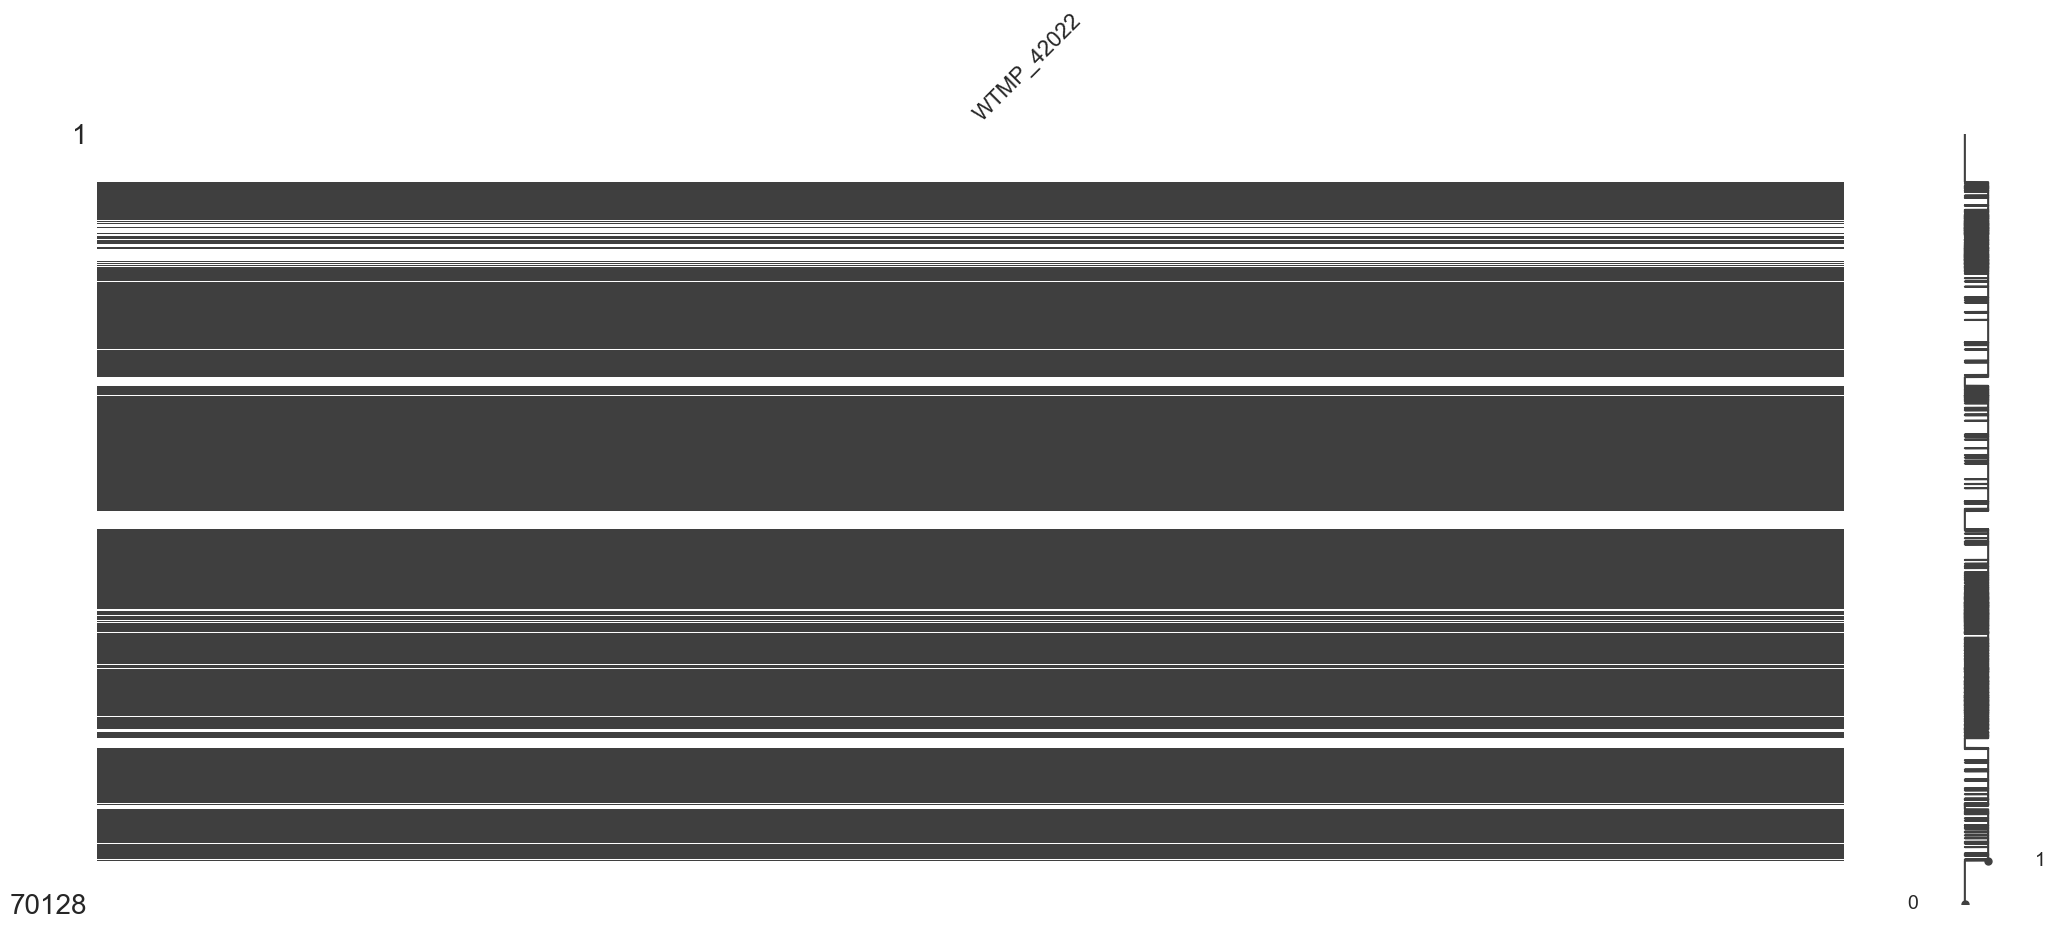

In [9]:
print("NaN values: ", data.isna().sum().sum())
msno.matrix(data)

NaN values:  8097


<AxesSubplot:>

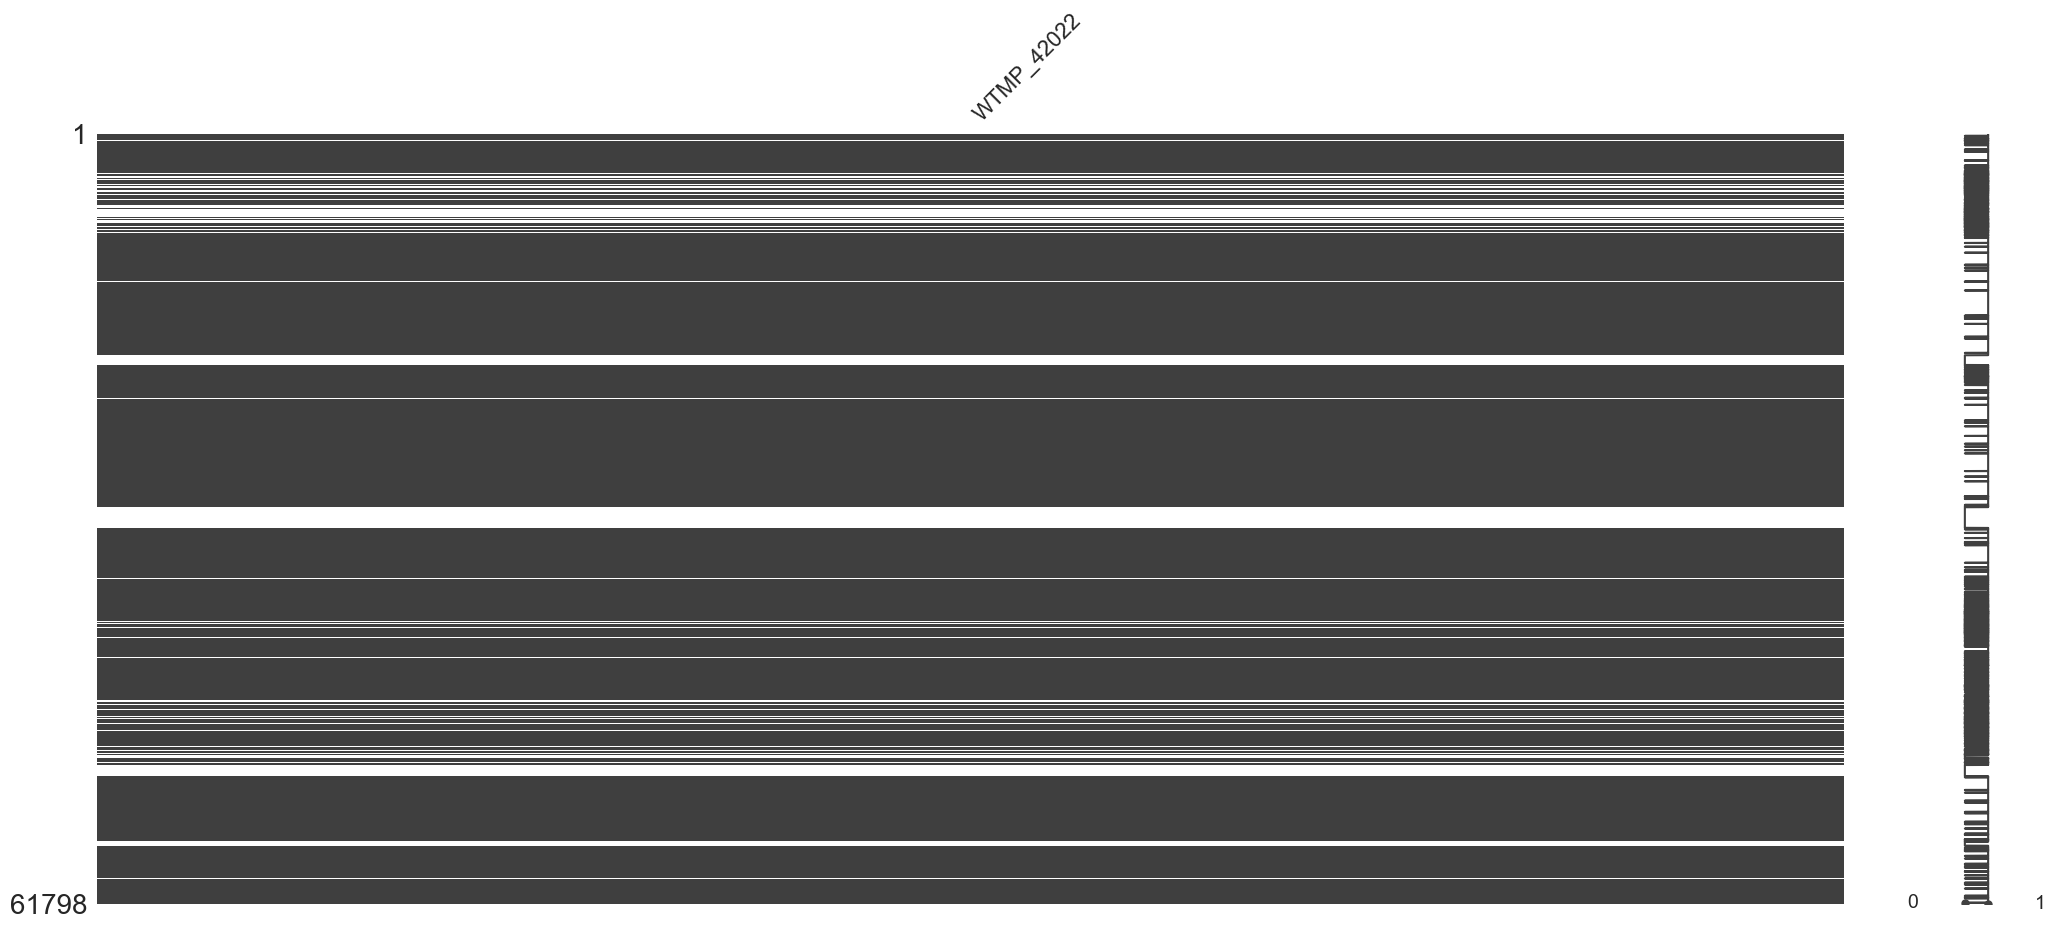

In [10]:
first_index = data.dropna().index[0]
last_index = data.dropna().index[-1]

data = data.loc[first_index:]
data = data.loc[:last_index]

print("NaN values: ", data.isna().sum().sum())
msno.matrix(data)

In [11]:
data.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data.isna().sum().sum())
#msno.matrix(data)

Remaining NaN values:  0


<AxesSubplot:xlabel='timestamp'>

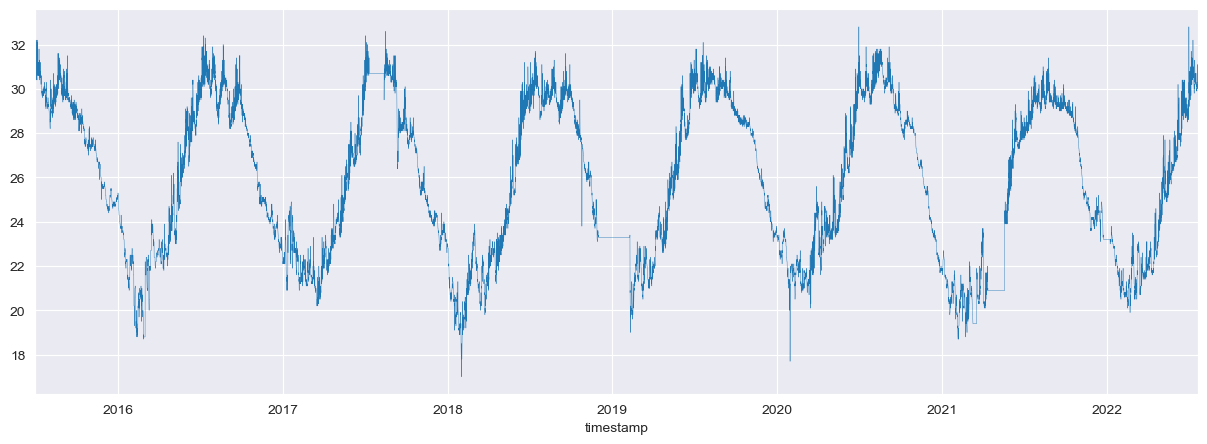

In [12]:
data["WTMP_42022"].plot(figsize=(15,5), lw=0.3)

In [13]:
test_hours = 7*24 #one week forecast

# split the dataframe into training and testing subsets
train = data.iloc[: -test_hours,:]
test = data.iloc[-test_hours:, :]

In [14]:
train

,WTMP_42022
timestamp,
2015-07-02 14:00:00,30.5
2015-07-02 15:00:00,30.6
2015-07-02 16:00:00,30.7
2015-07-02 17:00:00,31.0
2015-07-02 18:00:00,31.3
...,...
2022-07-13 07:00:00,30.2
2022-07-13 08:00:00,30.1
2022-07-13 09:00:00,30.1


In [15]:
test

,WTMP_42022
timestamp,
2022-07-13 12:00:00,30.0
2022-07-13 13:00:00,30.1
2022-07-13 14:00:00,30.1
2022-07-13 15:00:00,30.2
2022-07-13 16:00:00,30.3
...,...
2022-07-20 07:00:00,30.5
2022-07-20 08:00:00,30.3
2022-07-20 09:00:00,30.5


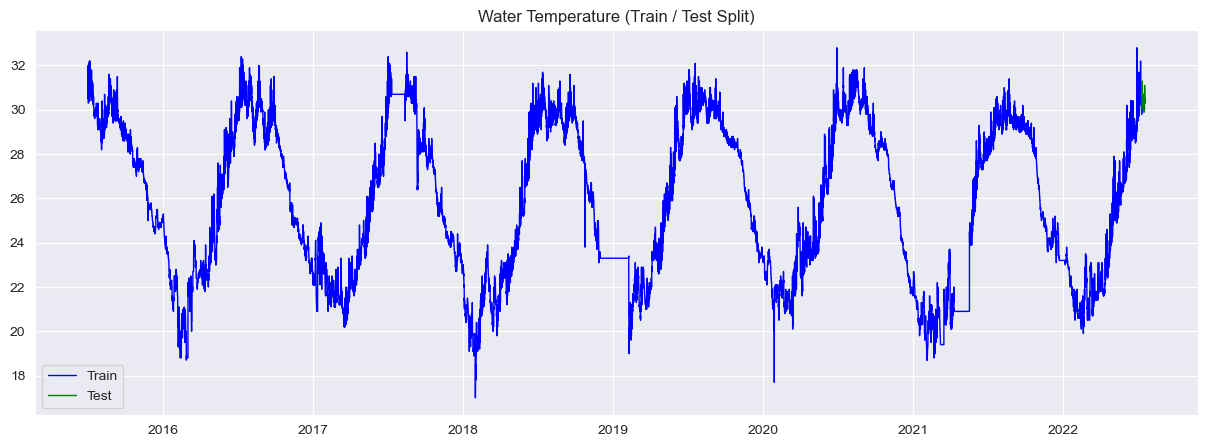

In [16]:
# create a figure and axes objects with figsize
fig, ax = plt.subplots(figsize=(15, 5))

# plot the train and test data
ax.plot(train.index, train['WTMP_42022'], color='blue', label='Train', lw=1)
ax.plot(test.index, test['WTMP_42022'], color='green', label='Test', lw = 1)

# add heading and legend to the chart
ax.set_title('Water Temperature (Train / Test Split)')
ax.legend()

# display the chart
plt.show()

In [ ]:
model = auto_arima(y=train.WTMP_42022,
                   m= 24    #Seasonal component (daily)
                   )

Started model training on April 10 at 12:08